# The Thingi10k Dataset

Thingi10k is a dataset published by a group of researchers and made publicly available via its website: https://ten-thousand-models.appspot.com/

Unfortunately, the Thingi10k repo comes with no extra data beyond the STL files themselves. Lucky for us, Thingi10k has unknowingly exposed the API it uses to show common file metrics on its website.

Example object with metrics: https://ten-thousand-models.appspot.com/detail.html?file_id=32770

## The Thingi10k API

By using the Chrome Developer Tools, we can monitor network traffic during page load to sniff out the path to the Thingi10k API. For the example linked above, the API endpoint is https://ten-thousand-models.appspot.com/api/v1/model/32770.

The final number is the file id, meaning that we can iterate through the files, create the api endpoint, and extract data for each.

## Retrieving Metrics PoC

In [1]:
import requests


def api_json(url):
    print('api_query: {}'.format(url))
    resp = requests.get(url=url)
    data = None
    if resp.status_code != 200:
        print('failed to retrieve data from {0}'.format(url))
        print('status_code={0}'.format(resp.status_code))
    else:
        data = resp.json()
    return data


def thingi10k_api_data(file_id):
    url = 'https://ten-thousand-models.appspot.com/api/v1/model/{}'.format(file_id)
    return api_json(url)


data = thingi10k_api_data(32770)
data

api_query: https://ten-thousand-models.appspot.com/api/v1/model/32770


{'orientable': 1,
 'ave_dihedral_angle': 0.0870997,
 'subcategory': 'None',
 'median_area': 0.0498815,
 'min_valance': 3.0,
 'total_area': 8841.26,
 'p95_dihedral_angle': 0.325493,
 'p90_valance': 6.0,
 'p75_dihedral_angle': 0.0718022,
 'num_complanar_intersecting_faces': 0,
 'num_boundary_edges': 0,
 'vertex_manifold': 1,
 'p95_valance': 7.0,
 'num_connected_components': 1,
 'ave_valance': 5.99937,
 'p95_area': 1.04975,
 'category': 'None',
 'euler_characteristic': 2,
 'max_area': 60.1549,
 'author': 'BrianEnigma',
 'min_dihedral_angle': 5.29428e-24,
 'median_valance': 6.0,
 'p75_aspect_ratio': 1.76379,
 'p90_dihedral_angle': 0.170165,
 'p75_valance': 6.0,
 'num_vertices': 18944,
 'min_aspect_ratio': 1.00003,
 'p95_aspect_ratio': 3.41081,
 'num_faces': 37884,
 'p25_valance': 6.0,
 'num_self_intersections': 0,
 'publish_time': '2011-07-26T09:23:59',
 'p90_aspect_ratio': 2.51872,
 'tags': ['cat', '3D', 'makerbot', 'octocat', 'octopus'],
 'p75_area': 0.0687898,
 'max_valance': 34.0,
 'p9

It works!

### Retrieving Rendered Image PoC

Another nice-to-have would be a pre-rendered image of the STL object. Those are available on the website, so perhaps we can scrape those, too?

The url of the image for the example object above is https://storage.googleapis.com/thingi10k/renderings/32770.png.

img_query: https://storage.googleapis.com/thingi10k/renderings/32770.png


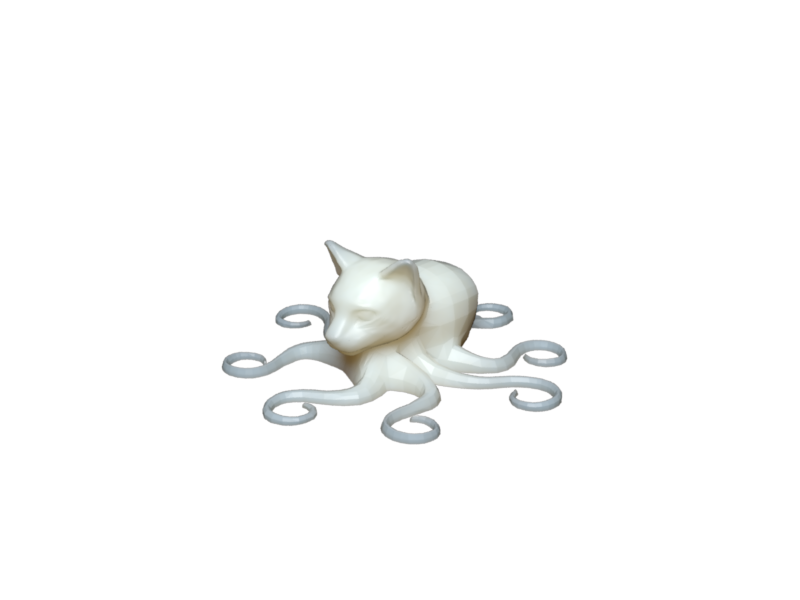

In [2]:
# https://stackoverflow.com/questions/3042757/downloading-a-picture-via-urllib-and-python
# https://docs.python.org/3.0/library/urllib.request.html#urllib.request.urlretrieve
import urllib.request
import shutil


def thingi10k_image(file_id, dest):
    url = 'https://storage.googleapis.com/thingi10k/renderings/{}.png'.format(file_id)
    print('img_query: {}'.format(url))
    filename, headers = urllib.request.urlretrieve(url)
    shutil.move(filename, dest)
    return dest


img = thingi10k_image(32770, '_output/thingi10k_octocat.png')


from IPython.display import Image
Image(img)

### Building a Thingi10k Model Index

Now that we know how to 

1. Read and manipulate STL files
2. Render STL meshes in python
3. Download additional data on each model
4. Download a rendered image of each model

We can build an index combining this information for easy retrieval. The index will be a csv file with a column for each attribute seen in the Thingi10k API and additional columns for STL file path and image path.

The index will live in the processed dir. The images and json will live in the raw dir.

In [3]:
import json
import csv
import os

rows = list()
header = ['file', 'name', 'num_vertices']

mesh_dir = '../data/external/Thingi10k/raw_meshes'
raw_dir = '../data/raw'
proc_dir = '../data/processed'

fields = list()
data = list()

for path in os.listdir(mesh_dir)[:10]:
    
    # quick check that we are reading something that we care about
    if not path.endswith('.stl'):
        print('not an stl file: {}'.format(path))
        continue
    
    # get file ids
    file_id = os.path.splitext(path)[0]
    
    # get api data
    file_data = thingi10k_api_data(file_id)
    stl_name = '{}.json'.format(file_id)
    with open(os.path.join(raw_dir, stl_name), 'w') as outfile:
        json.dump(data, outfile)

    # gather object images
    img_name = '{}.png'.format(file_id)
    dest = os.path.join(raw_dir, img_name)
    dest = thingi10k_image(file_id, dest)
        
    # done
    file_data['stl_file'] = stl_name
    file_data['img_file'] = img_name
    fields = list(set(fields).union(set(file_data.keys())))
    data.append(file_data)


api_query: https://ten-thousand-models.appspot.com/api/v1/model/100026
img_query: https://storage.googleapis.com/thingi10k/renderings/100026.png
api_query: https://ten-thousand-models.appspot.com/api/v1/model/100027
img_query: https://storage.googleapis.com/thingi10k/renderings/100027.png
api_query: https://ten-thousand-models.appspot.com/api/v1/model/100028
img_query: https://storage.googleapis.com/thingi10k/renderings/100028.png
api_query: https://ten-thousand-models.appspot.com/api/v1/model/100029
img_query: https://storage.googleapis.com/thingi10k/renderings/100029.png
api_query: https://ten-thousand-models.appspot.com/api/v1/model/100030
img_query: https://storage.googleapis.com/thingi10k/renderings/100030.png
api_query: https://ten-thousand-models.appspot.com/api/v1/model/100036
img_query: https://storage.googleapis.com/thingi10k/renderings/100036.png
api_query: https://ten-thousand-models.appspot.com/api/v1/model/100037
img_query: https://storage.googleapis.com/thingi10k/renderi

In [4]:
# write index
index_path = '_output/thingi10k.csv'
with open(index_path, 'w', newline='') as csvfile:

    writer = csv.DictWriter(csvfile, fieldnames=fields)

    writer.writeheader()
    for i, obj in enumerate(data):
        # https://stackoverflow.com/questions/1285911/how-do-i-check-that-multiple-keys-are-in-a-dict-in-a-single-passs
        # make sure that this obj has all the right fields
        if set(fields) <= set(obj):
            for f in fields:
                if not obj.get(f, None):
                    obj[f] = None
        
        writer.writerow(obj)

In [5]:
import pandas as pd


df = pd.read_csv(index_path)
df

,max_area,p95_dihedral_angle,min_dihedral_angle,ave_dihedral_angle,num_boundary_edges,ave_valance,p75_aspect_ratio,p90_area,p90_valance,p90_dihedral_angle,...,tags,PWN,publish_time,num_connected_components,num_faces,p25_dihedral_angle,p75_valance,num_self_intersections,edge_manifold,num_duplicated_faces
0,796.6830,1.57080,NaN,0.687029,NaN,6.78632,12.16600,174.71300,9.4,1.570800,...,"['aircraft', 'hobby', 'model', 'RC', 'RC_plane...",NaN,2012-11-04T06:34:23,1,270,NaN,8.0,41.0,NaN,NaN
1,313.9930,1.57093,NaN,0.690393,NaN,6.65138,10.76080,24.62470,9.0,1.570800,...,"['aircraft', 'hobby', 'model', 'RC', 'RC_plane...",NaN,2012-11-04T06:34:23,1,508,NaN,8.0,148.0,NaN,3.0
2,80.0000,1.57080,NaN,0.643016,NaN,5.70000,4.83570,16.25000,6.1,1.570800,...,"['aircraft', 'hobby', 'model', 'RC', 'RC_plane...",1.0,2012-11-04T06:34:23,3,228,NaN,6.0,NaN,1.0,NaN
3,540.6710,1.82460,NaN,0.664232,2.0,6.68317,13.94350,124.97100,8.9,1.570800,...,"['aircraft', 'hobby', 'model', 'RC', 'RC_plane...",NaN,2012-11-04T06:34:23,2,452,NaN,7.0,78.0,NaN,NaN
4,1982.9500,1.57315,NaN,0.539553,5.0,6.89803,33.62180,60.53090,9.0,1.570810,...,"['aircraft', 'hobby', 'model', 'RC', 'RC_plane...",NaN,2012-11-04T06:34:23,1,1504,0.000042,8.0,98.0,NaN,5.0
5,220.5500,1.57080,NaN,0.591520,1.0,5.95122,16.95310,22.04230,7.0,1.570800,...,"['aircraft', 'hobby', 'model', 'RC', 'RC_plane...",NaN,2012-11-04T06:34:23,1,252,NaN,6.0,11.0,NaN,7.0
6,199.5000,1.57080,NaN,0.568330,3.0,6.22099,15.68570,18.30890,9.0,1.570800,...,"['aircraft', 'hobby', 'model', 'RC', 'RC_plane...",NaN,2012-11-04T06:34:23,1,375,NaN,6.0,12.0,NaN,NaN
7,1.7199,1.57080,NaN,0.592873,NaN,6.05769,7.49266,0.84000,8.0,1.570800,...,"['3D', 'arduino', 'PrintBot', 'robot', 'robota...",1.0,2012-11-18T08:54:47,3,420,NaN,6.0,188.0,1.0,NaN
8,665.0000,0.34432,NaN,0.151410,NaN,6.00000,2.71220,2.60064,6.0,0.165635,...,"['3D', 'cube', 'LulzBot', 'makerbot', 'man', '...",1.0,2012-11-18T14:06:17,1,5030,0.000013,6.0,NaN,1.0,NaN
9,492.0000,1.57080,NaN,0.566623,24.0,6.00000,60.68470,22.75000,7.0,1.570800,...,"['3D', 'cube', 'LulzBot', 'makerbot', 'man', '...",NaN,2012-11-18T14:06:17,1,1070,NaN,6.0,NaN,1.0,NaN
